In [55]:
!pip install tensorflow tensorflow-io matplotlib

In [56]:
import os #allow us to use OS directory paths
from matplotlib import pyplot as plt #for graphic/ wave format
import tensorflow as tf #used for data manipulation
import tensorflow_io as tfio

In [57]:
m16sound = os.path.join('archive', 'M16', '5 (1).wav')
ak47sound = os.path.join('archive', 'AK-47', '1 (1).wav')

In [58]:
m16sound

'archive\\M16\\5 (1).wav'

In [59]:
def load_wav_16k_mono(filename): #convert in 16hz in a mono channel
    file_contents = tf.io.read_file(filename)
    wav, sample_rate = tf.audio.decode_wav(file_contents, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

In [61]:
m16wave = load_wav_16k_mono(m16sound)
akwave = load_wav_16k_mono(ak47sound)

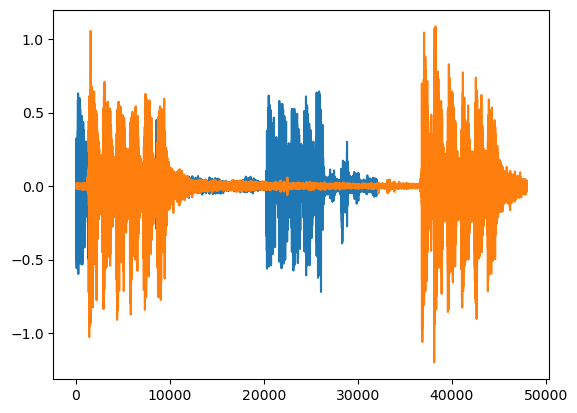

In [62]:
plt.plot(m16wave)
plt.plot(akwave)
plt.show()

In [63]:
ZASTAVA = os.path.join('archive', 'Zastava_M92') #defining varibles holding different paths as strings
MP5 = os.path.join('archive', 'MP5')
MG42 = os.path.join('archive', 'MG-42')
M249 = os.path.join('archive', 'M249')
M16 = os.path.join('archive', 'M16')
M4 = os.path.join('archive', 'M4')
IMI = os.path.join('archive', 'IMI_Desert_Eagle')
AK47 = os.path.join('archive', 'AK-47')
AK12 = os.path.join('archive', 'AK-12')

In [64]:
zastava = tf.data.Dataset.list_files(ZASTAVA+'\*.wav') #getting all files in each directory path
mp5 = tf.data.Dataset.list_files(MP5+'\*.wav')
mg42 = tf.data.Dataset.list_files(MG42+'\*.wav')
m249 = tf.data.Dataset.list_files(M249+'\*.wav')
m16 = tf.data.Dataset.list_files(M16+'\*.wav')
m4 = tf.data.Dataset.list_files(M4+'\*.wav')
imi = tf.data.Dataset.list_files(IMI+'\*.wav')
ak47 = tf.data.Dataset.list_files(AK47+'\*.wav')
ak12 = tf.data.Dataset.list_files(AK12+'\*.wav')

In [65]:
zastavas = tf.data.Dataset.zip((zastava, tf.data.Dataset.from_tensor_slices(tf.ones(len(zastava))))) #if the sound is contained within the folder, lets return 1s
mp5s = tf.data.Dataset.zip((mp5, tf.data.Dataset.from_tensor_slices(tf.ones(len(mp5)))))
mg42s = tf.data.Dataset.zip((mg42, tf.data.Dataset.from_tensor_slices(tf.ones(len(mg42)))))
m249s = tf.data.Dataset.zip((m249, tf.data.Dataset.from_tensor_slices(tf.ones(len(m249)))))
m16s = tf.data.Dataset.zip((m16, tf.data.Dataset.from_tensor_slices(tf.ones(len(m16)))))
m4s = tf.data.Dataset.zip((m4, tf.data.Dataset.from_tensor_slices(tf.ones(len(m4)))))
imis = tf.data.Dataset.zip((imi, tf.data.Dataset.from_tensor_slices(tf.ones(len(imi)))))
ak47s = tf.data.Dataset.zip((ak47, tf.data.Dataset.from_tensor_slices(tf.ones(len(ak47)))))
ak12s = tf.data.Dataset.zip((ak12, tf.data.Dataset.from_tensor_slices(tf.ones(len(ak12)))))
data = zastavas.concatenate(mp5s).concatenate(mg42s).concatenate(m249s).concatenate(m16s).concatenate(m4s).concatenate(imis).concatenate(ak47s).concatenate(ak12s)

In [66]:
lengths = []
for file in os.listdir(AK47):
    tensor_wave = load_wav_16k_mono(os.path.join('archive', 'AK-47', file))
    lengths.append(len(tensor_wave))

In [42]:
lengths

[48000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 64000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 48000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000,
 32000]

In [43]:
tf.math.reduce_mean(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32888>

In [44]:
tf.math.reduce_min(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=32000>

In [45]:
tf.math.reduce_max(lengths)

<tf.Tensor: shape=(), dtype=int32, numpy=64000>

In [68]:
def preprocess(file_path, label): #preprocessing the audio.
    wav = load_wav_16k_mono(file_path) #this path referes to whatever will be coming from a microphone
    wav = wav[:40000]
    zero_padding = tf.zeros([40000] - tf.shape(wav), dtype=tf.float32)#whatever sound does not meat the length will be padded with zeros to avoid errors
    wav = tf.concat([zero_padding, wav], 0) #concatenating the padded zeros
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

In [69]:
filepath, label = zastavas.shuffle(buffer_size=100).as_numpy_iterator().next()
spectrogram, label = preprocess(filepath, label)

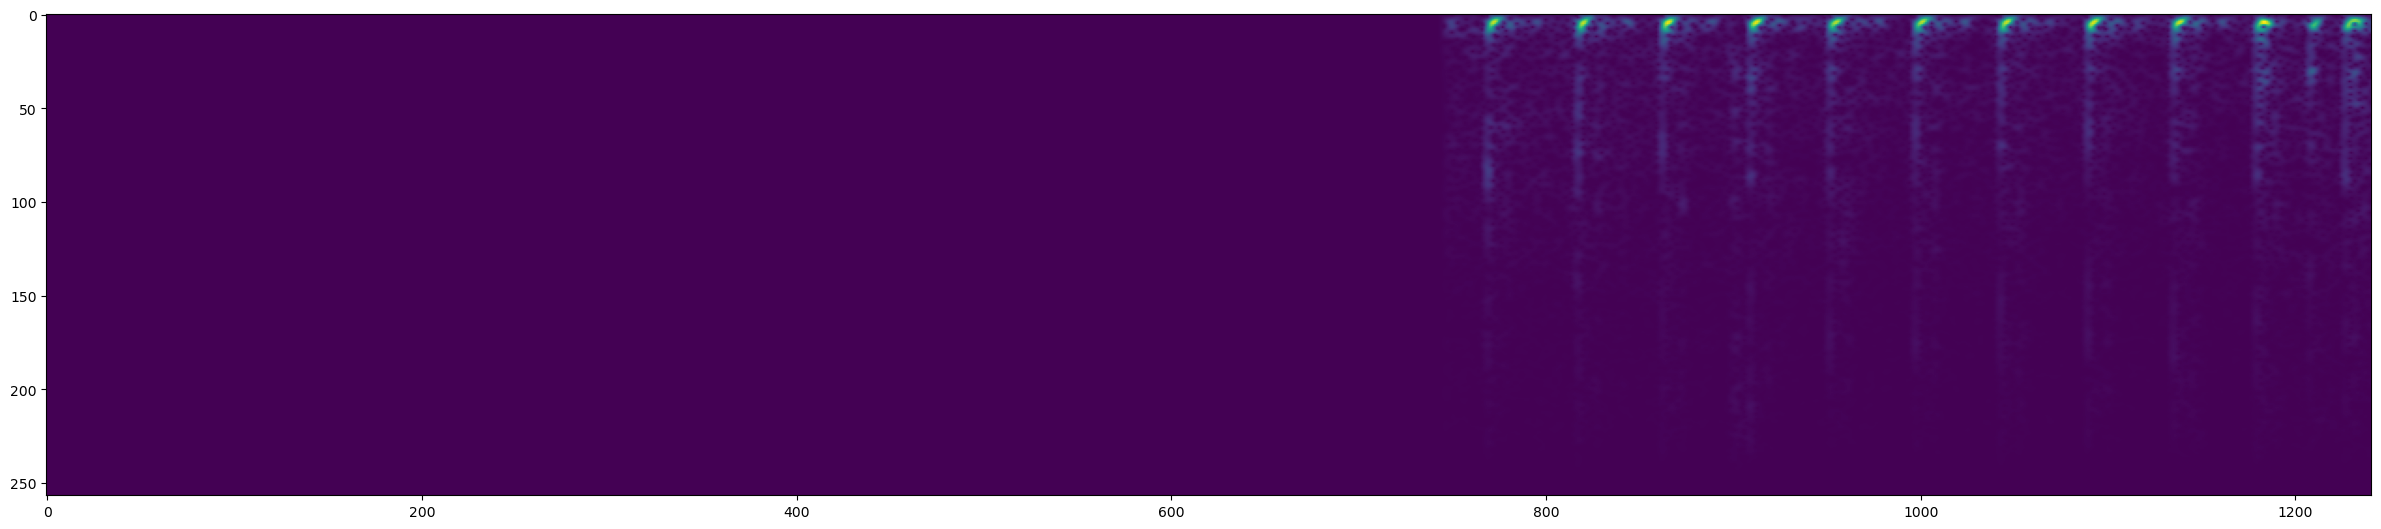

In [70]:
plt.figure(figsize=(30,20))
plt.imshow(tf.transpose(spectrogram)[0])
plt.show()

In [71]:
data = data.map(preprocess) #the error is due to the no concat when reading multiple files from multiple directories
data = data.cache() # the repare approach will be to put all audio file into one directory named gunshot, then replace archive in this cell
data = data.shuffle(buffer_size=1000)
data = data.batch(16)
data = data.prefetch(8)

In [21]:
len(data)*.7

37.8

In [73]:
train = data.take(38)
test = data.skip(38).take(15)

In [74]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

In [75]:
model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257, 1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

In [76]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [77]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 conv2d_5 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten_2 (Flatten)         (None, 6019376)           0         
                                                                 
 dense_4 (Dense)             (None, 128)               770480256 
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                                 
Total params: 770,482,865
Trainable params: 770,482,865
Non-trainable params: 0
_________________________________________________________________


In [78]:
hist = model.fit(train, epochs=10, validation_data=test)

Epoch 1/10


InvalidArgumentError: Graph execution error:

Detected at node 'sequential_2/flatten_2/Reshape' defined at (most recent call last):
    File "C:\Users\ak\anaconda3\lib\runpy.py", line 197, in _run_module_as_main
      return _run_code(code, main_globals, None,
    File "C:\Users\ak\anaconda3\lib\runpy.py", line 87, in _run_code
      exec(code, run_globals)
    File "C:\Users\ak\anaconda3\lib\site-packages\ipykernel_launcher.py", line 17, in <module>
      app.launch_new_instance()
    File "C:\Users\ak\anaconda3\lib\site-packages\traitlets\config\application.py", line 846, in launch_instance
      app.start()
    File "C:\Users\ak\anaconda3\lib\site-packages\ipykernel\kernelapp.py", line 712, in start
      self.io_loop.start()
    File "C:\Users\ak\anaconda3\lib\site-packages\tornado\platform\asyncio.py", line 199, in start
      self.asyncio_loop.run_forever()
    File "C:\Users\ak\anaconda3\lib\asyncio\base_events.py", line 601, in run_forever
      self._run_once()
    File "C:\Users\ak\anaconda3\lib\asyncio\base_events.py", line 1905, in _run_once
      handle._run()
    File "C:\Users\ak\anaconda3\lib\asyncio\events.py", line 80, in _run
      self._context.run(self._callback, *self._args)
    File "C:\Users\ak\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 510, in dispatch_queue
      await self.process_one()
    File "C:\Users\ak\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 499, in process_one
      await dispatch(*args)
    File "C:\Users\ak\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 406, in dispatch_shell
      await result
    File "C:\Users\ak\anaconda3\lib\site-packages\ipykernel\kernelbase.py", line 730, in execute_request
      reply_content = await reply_content
    File "C:\Users\ak\anaconda3\lib\site-packages\ipykernel\ipkernel.py", line 390, in do_execute
      res = shell.run_cell(code, store_history=store_history, silent=silent)
    File "C:\Users\ak\anaconda3\lib\site-packages\ipykernel\zmqshell.py", line 528, in run_cell
      return super().run_cell(*args, **kwargs)
    File "C:\Users\ak\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2914, in run_cell
      result = self._run_cell(
    File "C:\Users\ak\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 2960, in _run_cell
      return runner(coro)
    File "C:\Users\ak\anaconda3\lib\site-packages\IPython\core\async_helpers.py", line 78, in _pseudo_sync_runner
      coro.send(None)
    File "C:\Users\ak\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3185, in run_cell_async
      has_raised = await self.run_ast_nodes(code_ast.body, cell_name,
    File "C:\Users\ak\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3377, in run_ast_nodes
      if (await self.run_code(code, result,  async_=asy)):
    File "C:\Users\ak\anaconda3\lib\site-packages\IPython\core\interactiveshell.py", line 3457, in run_code
      exec(code_obj, self.user_global_ns, self.user_ns)
    File "C:\Users\ak\AppData\Local\Temp\ipykernel_8664\3513761044.py", line 1, in <module>
      hist = model.fit(train, epochs=10, validation_data=test)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\engine\training.py", line 1650, in fit
      tmp_logs = self.train_function(iterator)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\engine\training.py", line 1249, in train_function
      return step_function(self, iterator)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\engine\training.py", line 1233, in step_function
      outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\engine\training.py", line 1222, in run_step
      outputs = model.train_step(data)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\engine\training.py", line 1023, in train_step
      y_pred = self(x, training=True)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\engine\training.py", line 561, in __call__
      return super().__call__(*args, **kwargs)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\engine\sequential.py", line 413, in call
      return super().call(inputs, training=training, mask=mask)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\engine\functional.py", line 511, in call
      return self._run_internal_graph(inputs, training=training, mask=mask)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\engine\functional.py", line 668, in _run_internal_graph
      outputs = node.layer(*args, **kwargs)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 65, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\engine\base_layer.py", line 1132, in __call__
      outputs = call_fn(inputs, *args, **kwargs)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\utils\traceback_utils.py", line 96, in error_handler
      return fn(*args, **kwargs)
    File "C:\Users\ak\anaconda3\lib\site-packages\keras\layers\reshaping\flatten.py", line 104, in call
      return tf.reshape(inputs, flattened_shape)
Node: 'sequential_2/flatten_2/Reshape'
Input to reshape is a tensor with 80118016 values, but the requested shape requires a multiple of 6019376
	 [[{{node sequential_2/flatten_2/Reshape}}]] [Op:__inference_train_function_19608]